# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from utils import model_inputs, get_flow_dataset, train_test_split
from models import generator, discriminator

In [3]:
dataset = get_flow_dataset()
train, test = train_test_split(dataset, 0.8)

In [4]:
train.shape

(16000, 40)

In [5]:
test.shape

(4000, 40)

## Hyperparameters

In [6]:
# Size of input image to discriminator
input_size = 40
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_real, input_z` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, input_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for real data and one for fake data. Since we want the weights to be the same for both real and fake data, we need to reuse the variables. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

In [7]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_loss_real + d_loss_fake`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the images in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(tensor) * (1 - smooth)`

The discriminator loss for the fake data is similar. The logits are `d_logits_fake`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_fake`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

In [8]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [9]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [10]:
batch_size = 100
epochs = 200
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(train.shape[0]//batch_size):
            batch_real = train[ii * batch_size:(ii + 1) * batch_size]
            
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_real, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_real})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1/200... Discriminator Loss: 0.3389... Generator Loss: 5.9586
Epoch 2/200... Discriminator Loss: 0.3293... Generator Loss: 7.7626
Epoch 3/200... Discriminator Loss: 0.3290... Generator Loss: 7.1964
Epoch 4/200... Discriminator Loss: 0.3282... Generator Loss: 6.8510
Epoch 5/200... Discriminator Loss: 0.3269... Generator Loss: 10.6777
Epoch 6/200... Discriminator Loss: 0.3267... Generator Loss: 11.0285
Epoch 7/200... Discriminator Loss: 0.3267... Generator Loss: 8.7173
Epoch 8/200... Discriminator Loss: 0.3274... Generator Loss: 6.8933
Epoch 9/200... Discriminator Loss: 0.3263... Generator Loss: 10.7104
Epoch 10/200... Discriminator Loss: 0.3288... Generator Loss: 12.8962
Epoch 11/200... Discriminator Loss: 0.3262... Generator Loss: 10.1557
Epoch 12/200... Discriminator Loss: 0.3264... Generator Loss: 13.4282
Epoch 13/200... Discriminator Loss: 0.3256... Generator Loss: 11.4605
Epoch 14/200... Discriminator Loss: 0.3269... Generator Loss: 7.1222
Epoch 15/200... Discriminator Loss: 

Epoch 119/200... Discriminator Loss: 0.3251... Generator Loss: 20.8689
Epoch 120/200... Discriminator Loss: 0.3251... Generator Loss: 20.5581
Epoch 121/200... Discriminator Loss: 0.3251... Generator Loss: 20.9778
Epoch 122/200... Discriminator Loss: 0.3251... Generator Loss: 20.8783
Epoch 123/200... Discriminator Loss: 0.3251... Generator Loss: 20.7351
Epoch 124/200... Discriminator Loss: 0.3251... Generator Loss: 21.1605
Epoch 125/200... Discriminator Loss: 0.3251... Generator Loss: 21.6736
Epoch 126/200... Discriminator Loss: 0.3251... Generator Loss: 17.6213
Epoch 127/200... Discriminator Loss: 0.3255... Generator Loss: 12.9143
Epoch 128/200... Discriminator Loss: 0.3251... Generator Loss: 16.5004
Epoch 129/200... Discriminator Loss: 0.3251... Generator Loss: 17.2150
Epoch 130/200... Discriminator Loss: 0.3251... Generator Loss: 17.8838
Epoch 131/200... Discriminator Loss: 0.3251... Generator Loss: 18.2379
Epoch 132/200... Discriminator Loss: 0.3251... Generator Loss: 18.5533
Epoch 

## Training loss

Here we'll check out the training losses for the generator and discriminator.

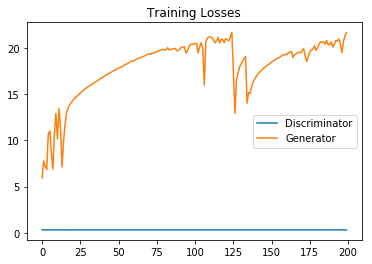

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()